In [1]:
# Imports
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

In [4]:
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

In [5]:
resp_all = torch.Tensor(resp_all)
stimuli_all = torch.Tensor(stimuli_all)
w1 = torch.autograd.Variable(torch.randn(23589,30)/20000,requires_grad = True)
b = torch.autograd.Variable(torch.randn(1,30)/30,requires_grad = True)
w2 = torch.autograd.Variable(torch.rand(30,1)/30,requires_grad = True)
m = torch.nn.ReLU()

class net1():
    def forward(w1,w2,b):
        a = m(torch.matmul(resp_all,w1)+b)
        y = torch.matmul(a,w2)
        L = torch.sum((y-stimuli_all)**2)/360
        return L

loss_list = []
optimizer = torch.optim.SGD([w1,w2,b], 0.0002)

for i in range(2500):
    L = net1.forward(w1,w2,b)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    L1 = L.detach().numpy().copy()
    loss_list.append(L1)

9.050063e-06


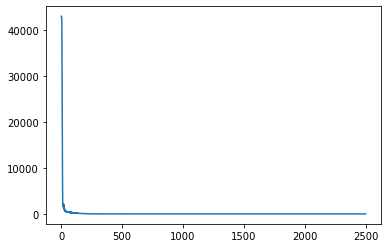

In [6]:
plt.plot(np.array(loss_list))
print(loss_list[-1])

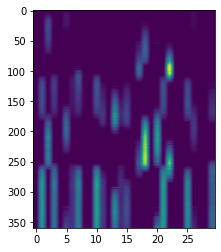

In [7]:
a = m(torch.matmul(resp_all,w1)+b)
plt.imshow(a.detach().numpy(),aspect = 0.1)

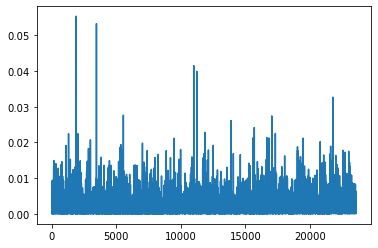

In [8]:
#contribution of neuron to hidden layer
contri = (torch.sum(w1**2,axis = 1)).detach().numpy()
plt.plot(contri)
contri_rank = np.flip(np.argsort(contri))

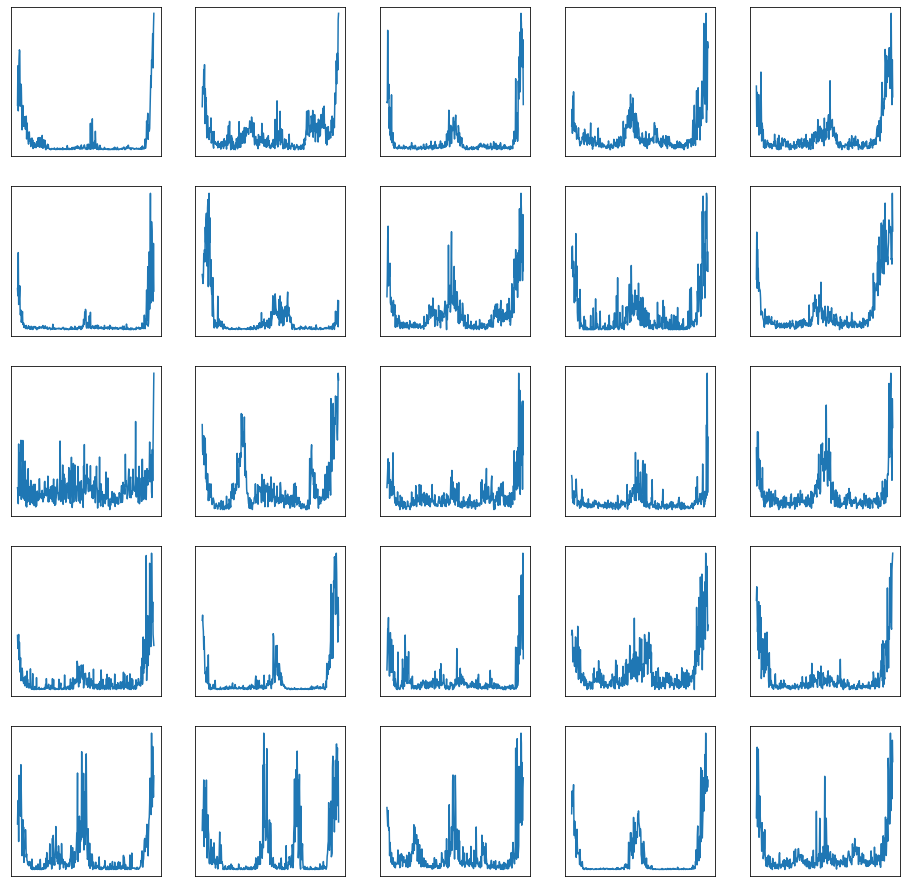

In [9]:
plt.rcParams["figure.figsize"] = (16,16)
fig,axs = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        ax.plot(np.array(resp_all)[:,contri_rank[5*i+j]])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_box_aspect(1)
plt.show()